# Benchmarking and Fine Tuning DistilBERT, MobileBERT, TinyBERT and ModernBERT for Fake News Detection
* Notebook by Adam Lang
* Date: 12/31/2024

# Overview
* In this notebook I will fine tune all 3 distilled BERT based models from hugging face AND perform benchmarking on their abilities to perform binary text classification.
* As mentioned, the models used will all be distilled BERT models:

1. DistilBERT
2. MobileBERT
3. TinyBERT

* In addition, I am going to benchmark these 3 distilled models against `bert-base` and the new `modern-bert` model that was just released.
  * As a reminder, the new modern-bert model was recently released, here is an excellent overview of the model: https://www.philschmid.de/fine-tune-modern-bert-in-2025

# NLP Task: Text Classification
* The NLP task here will be text classification.
* We will use the "Kaggle Fake News" Dataset: https://www.kaggle.com/c/fake-news/data

# Install Dependencies
* Make sure to install all dependencies.

In [1]:
## dependencies
%%capture
!pip install -U transformers accelerate datasets bertviz umap-learn
!pip install seaborn --upgrade
!pip install -U openpyxl ##excel library

## ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!pip install evaluate

In [51]:
## DS imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## imports for Machine learning
import time
import torch
import transformers
from datasets import Dataset, DatasetDict ## dataloaders for huggingface
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer ## finetuning
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

## Dataset import

In [4]:
## get data path
path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/BERT_transformers/fake_news.xlsx'

## upload data
df = pd.read_excel(path)
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Data preprocessing

In [5]:
## df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20757 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
## len of data
len(df)

20800

In [7]:
## columns
df.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [8]:
## check nulls
df.isnull().sum()

,0
id,0
title,558
author,1957
text,43
label,0


Summary
* There are quite a few nulls in the dataset.
* For now we will drop them.

In [9]:
## drop null
df = df.dropna()


## check nulls again
df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


Summary
* We can see the nulls were dropped without issues.

In [10]:
## check len of df now
len(df)

18281

# Exploratory Data Analysis (EDA)
* Lets do a quick EDA of the dataset.
* As a reminder of the metadata from kaggle:
    * `1: unreliable (fake)`
    * `0: reliable (not-fake)`

In [11]:
## target class EDA
label_cnt = df['label'].value_counts(ascending=True)
label_cnt

,count
label,
1,7920
0,10361


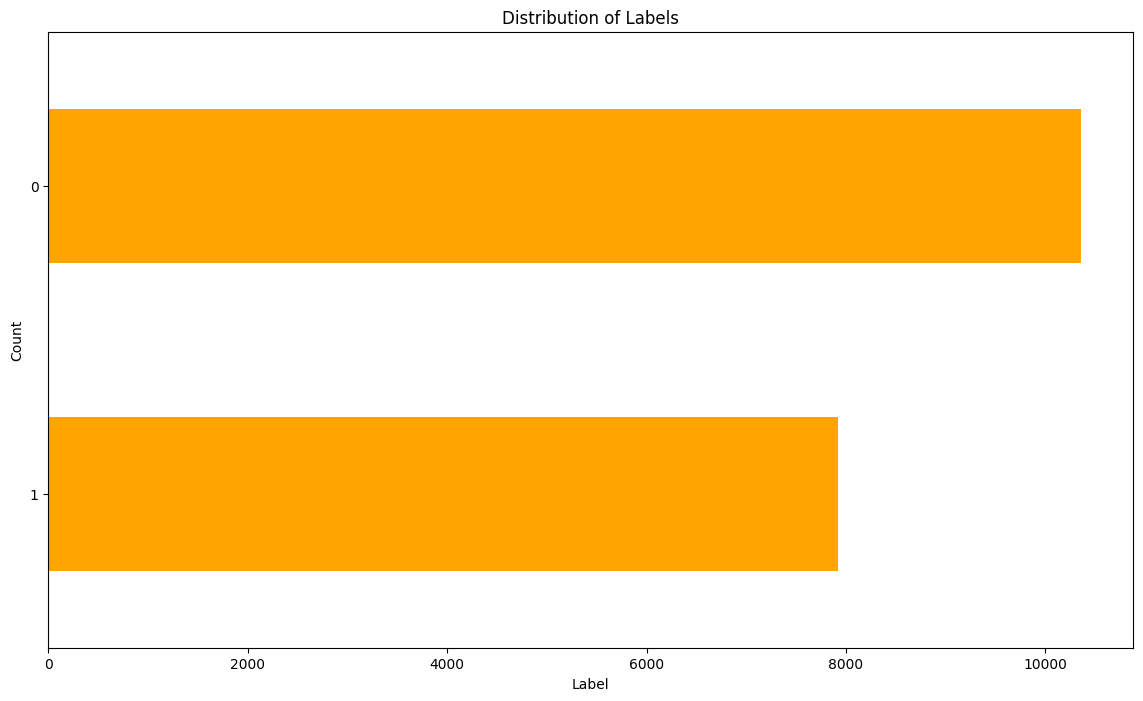

In [12]:
## plot this
plt.figure(figsize=(14, 8))

## bar plot
label_cnt.plot(kind='barh',color='orange')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show();

Summary
* Clearly as with most classification problems there is a target label class imbalance. The imbalance is not significant enough to deal with at the moment so we will leave as is and then re-evaluate after fine tuning the model and evaluating the model metrics and inference.

## Token Counting
* This is a prudent step in language modeling as we are dealing with a smaller model. As we know, BERT takes at max 512 tokens so we need to be weary of the token counts before we fine tune.
* The factor we are using is 1.5 tokens wer word.
* **We should also note that we are NOT preprocessing the text in anyway that you would in most "classical NLP" tasks such as: removing stop words, lemmatization/stemming, normalizing the text to upper or lowercase or other methods.
  * While this is common practice in most machine learning and classification modeling, we will not do that here.
  * That might be worth pursuing if we were performing topic modeling or clustering (unsupervised learning).
  * However, we will rely on the encoder seq2seq attention mechanism of BERT based model to work for classification.

In [13]:
## 1.5 tokens per word is average --> check this for `title` column
df['title'].apply(lambda x: len(x.split())*1.5).mean()

18.787538974891966

In [14]:
## check token count for text column
df['text'].apply(lambda x: len(x.split())*1.5).mean()

1183.443629998359

Summary
* For the Title column, this means that we will have around 18-20 tokens per title per row of the dataset.
* For the Text column this means the average num of tokens is 1183.

In [15]:
## reassign to new column the title token counts
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)

## reassign to new col text token counts
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)

In [16]:
## view the new columns
df.head()

,id,title,author,text,label,title_tokens,text_tokens
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,21.0,1230.0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,13.5,1065.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,10.5,1899.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15.0,835.5
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,21.0,231.0


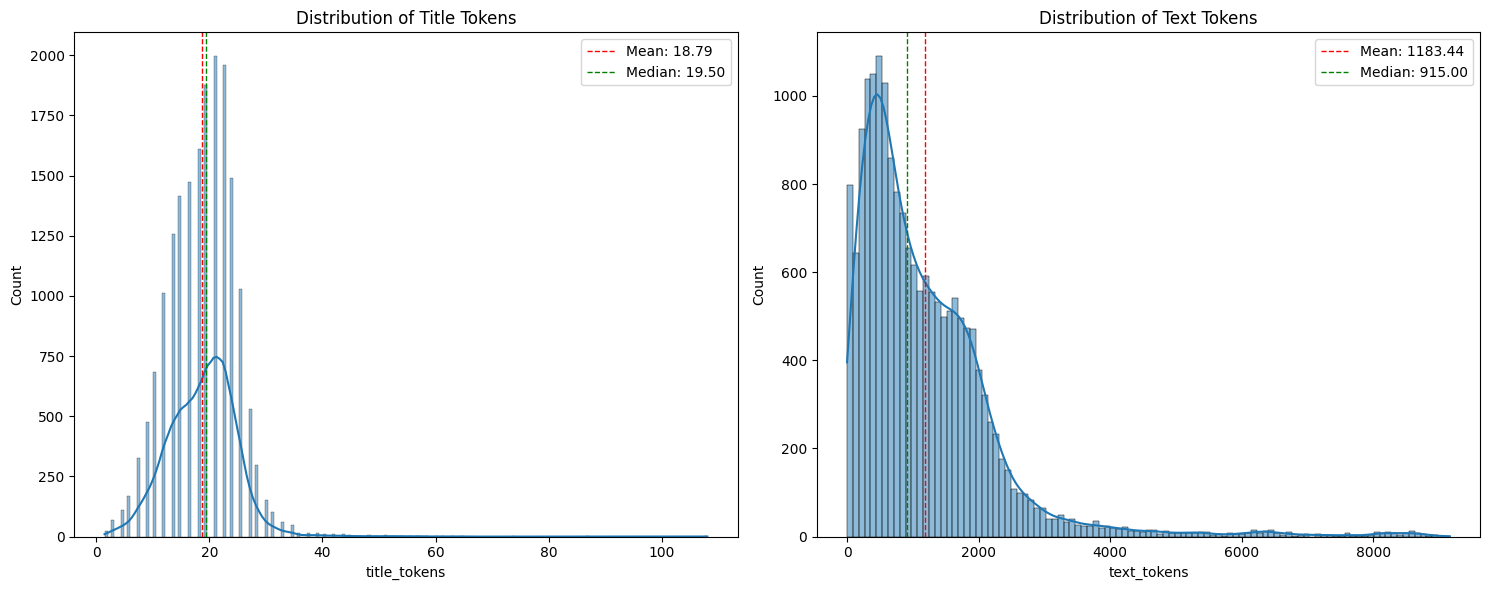

In [17]:
## plot with the mean and median
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: title_tokens distribution
sns.histplot(df['title_tokens'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Title Tokens')
axes[0].axvline(df['title_tokens'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {df["title_tokens"].mean():.2f}')
axes[0].axvline(df['title_tokens'].median(), color='green', linestyle='dashed', linewidth=1, label=f'Median: {df["title_tokens"].median():.2f}')
axes[0].legend()

# Plot 2: text_tokens distribution
sns.histplot(df['text_tokens'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Text Tokens')
axes[1].axvline(df['text_tokens'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {df["text_tokens"].mean():.2f}')
axes[1].axvline(df['text_tokens'].median(), color='green', linestyle='dashed', linewidth=1, label=f'Median: {df["text_tokens"].median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show();

Summary
* Plot above we can see the Text token mean and median are about twice as large as the max BERT token count which is 512.

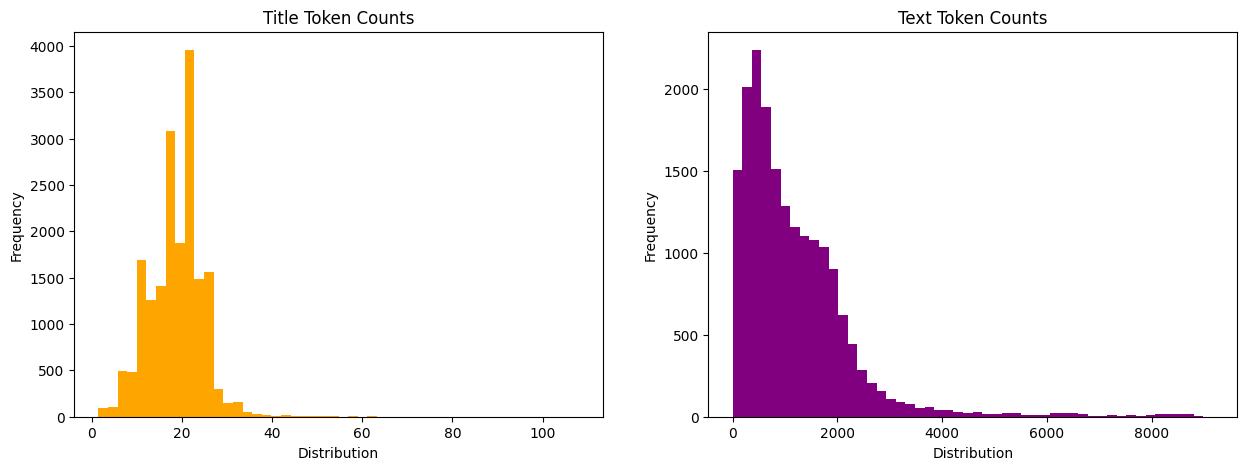

In [18]:
## plot these token counts
fig, ax = plt.subplots(1,2, figsize=(15,5))

## plot title tokens
ax[0].hist(df['title_tokens'],bins=50,color='orange')
ax[0].set_title('Title Token Counts')
ax[0].set_xlabel('Distribution')
ax[0].set_ylabel('Frequency')

## plot text tokens
ax[1].hist(df['text_tokens'],bins=50,color='purple')
ax[1].set_title('Text Token Counts')
ax[1].set_xlabel('Distribution')
ax[1].set_ylabel('Frequency')


plt.show();

Summary
* Since we are using a BERT based model and the max tokens are 512, we can see that most of the tokens in the Text column are well above 512 which means that:
  * 1) Either we have to choose a different language model that will factor in the token lengths of greater than 512
  * 2) Not use the Text tokens as a feature for prediction  --- what we are going to do here.
  * 3) Chunk the tokens in the Text column before input to BERT model.
  * 4) Use Modern BERT model which can take longer inputs, or use a model like BigBird or LongFormer or BERT for long sequences instead. However, the purpose of this exercise is to use a distilled BERT model.

# Data Loader & Train-Test Split
* Here we have to create the data loader and the train test split as with any machine learning problem.

## Train-Test Split

In [19]:
## perform train-test split --> 70 train, 20 test, 10 validation
train, test = train_test_split(df, test_size=0.3,stratify=df['label'])
test, valid = train_test_split(test, test_size=1/3, stratify=test['label']) ## Take 30% of test set for validation


## print shapes of each
print(f"Shape of train data: {train.shape}")
print(f"Shape of test data: {test.shape}")
print(f"Shape of validation data: {valid.shape}")

Shape of train data: (12796, 7)
Shape of test data: (3656, 7)
Shape of validation data: (1829, 7)


In [20]:
## info
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12796 entries, 20177 to 148
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            12796 non-null  int64  
 1   title         12796 non-null  object 
 2   author        12796 non-null  object 
 3   text          12796 non-null  object 
 4   label         12796 non-null  int64  
 5   title_tokens  12796 non-null  float64
 6   text_tokens   12796 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 799.8+ KB


## Data Loader
* Hugging face does not accept pandas dataframes for fine tuning so we need to convert to a dict which is the hugging face data format by using the huggingface api.

In [21]:
## create hf dataloader
dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False),
        'validation': Dataset.from_pandas(valid, preserve_index=False)
    }
)
## view dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

# Data Tokenization
* We will setup the tokenizers for all 3 models we are benchmarking
  * DistilBERT
      * model card: https://huggingface.co/distilbert/distilbert-base-uncased
  * MobileBERT
      * model card: https://huggingface.co/google/mobilebert-uncased
  * TinyBERT
      * model card: https://huggingface.co/huawei-noah/TinyBERT_General_4L_312D

In [43]:
# ModernBERT is not yet available in an official release, so we need to install it from github
%pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade



  Cloning https://github.com/huggingface/transformers.git (to revision 6e0515e99c39444caae39472ee1b2fd76ece32f1) to /tmp/pip-req-build-dbkimpcp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-dbkimpcp
  Running command git rev-parse -q --verify 'sha^6e0515e99c39444caae39472ee1b2fd76ece32f1'
  Running command git fetch -q https://github.com/huggingface/transformers.git 6e0515e99c39444caae39472ee1b2fd76ece32f1
  Running command git checkout -q 6e0515e99c39444caae39472ee1b2fd76ece32f1
  Resolved https://github.com/huggingface/transformers.git to commit 6e0515e99c39444caae39472ee1b2fd76ece32f1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [44]:
# from transformers import AutoTokenizer -- if not already done above

## test text
test_text = "Happy New Years from Australia!"


## 1. DistilBERT tokenizer and test tokens
model_ckpt = 'distilbert-base-uncased'
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(test_text)


## 2. MobileBERT tokenizer
mobile_ckpt = 'google/mobilebert-uncased'
mobilebert_tokenizer = AutoTokenizer.from_pretrained(mobile_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(test_text)


## 3. TinyBERT tokenizer
tiny_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'
tinybert_tokenizer = AutoTokenizer.from_pretrained(tiny_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(test_text)


## 4. Modern BERT tokenizer
mod_ckpt = 'google-bert/bert-base-uncased'
modbert_tokenizer = AutoTokenizer.from_pretrained(mod_ckpt)
modbert_tokens = modbert_tokenizer.tokenize(test_text)

In [45]:
## compare all 3 tokenizers
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer, modbert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=100

Summary
* Overall architectures of all 3 are a bit different but overall the same.
* Embedding sizes are different.
* Max token length is 512 for all 3 models.

DistilBERT tokenizer function

In [24]:
## function for tokenization using distilbert only
def tokenize(batch):
  temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
  return temp

### test out tokenizer on first few rows of train dataset
print(tokenize(dataset['train'][:3]))

{'input_ids': [[101, 1039, 1012, 1040, 1012, 1039, 1012, 4311, 22018, 6875, 2308, 1999, 1057, 1012, 1055, 1012, 2007, 1062, 7556, 1011, 1996, 2047, 2259, 2335, 102], [101, 2128, 1024, 27273, 2568, 7577, 1029, 2928, 10654, 8591, 2000, 8037, 1024, 1520, 2123, 1521, 1056, 6634, 1011, 3789, 999, 1521, 102, 0, 0], [101, 18520, 7207, 2003, 4292, 1037, 3040, 3993, 8132, 2005, 8398, 2000, 2969, 4078, 18300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


Summary of DistilBERT tokenizer
* There are no token_type_ids in the distilbert model as detailed in the paper.
* This is because next sentence prediction is not possible with DistilBERT.

MobileBERT tokenizer function

In [25]:
## function for tokenization using mobilebert only
def tokenize_mobile(batch):
  temp = mobilebert_tokenizer(batch['title'], padding=True, truncation=True)
  return temp

### test out tokenizer on first few rows of train dataset
print(tokenize_mobile(dataset['train'][:3]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[101, 1039, 1012, 1040, 1012, 1039, 1012, 4311, 22018, 6875, 2308, 1999, 1057, 1012, 1055, 1012, 2007, 1062, 7556, 1011, 1996, 2047, 2259, 2335, 102], [101, 2128, 1024, 27273, 2568, 7577, 1029, 2928, 10654, 8591, 2000, 8037, 1024, 1520, 2123, 1521, 1056, 6634, 1011, 3789, 999, 1521, 102, 0, 0], [101, 18520, 7207, 2003, 4292, 1037, 3040, 3993, 8132, 2005, 8398, 2000, 2969, 4078, 18300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


Summary
* We can see there are token_type_ids in the mobilebert model.

TinyBERT tokenizer function

In [26]:
## function for tokenization using mobilebert only
def tokenize_tiny(batch):
  temp = tinybert_tokenizer(batch['title'], padding=True, truncation=True)
  return temp

### test out tokenizer on first few rows of train dataset
print(tokenize_tiny(dataset['train'][:3]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[101, 1039, 1012, 1040, 1012, 1039, 1012, 4311, 22018, 6875, 2308, 1999, 1057, 1012, 1055, 1012, 2007, 1062, 7556, 1011, 1996, 2047, 2259, 2335, 102], [101, 2128, 1024, 27273, 2568, 7577, 1029, 2928, 10654, 8591, 2000, 8037, 1024, 1520, 2123, 1521, 1056, 6634, 1011, 3789, 999, 1521, 102, 0, 0], [101, 18520, 7207, 2003, 4292, 1037, 3040, 3993, 8132, 2005, 8398, 2000, 2969, 4078, 18300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


Summary
* We can see there are token_type_ids in tinybert as well.

## Map Tokenizer to dataset
* Here we will tokenize the dataset.
* We will start with the DistilBERT model.

In [27]:
## map dataset to tokenizer using distilbert

encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

# Model Building - DistilBERT, MobileBERT, TinyBERT
* Before we can do this, we have to create these 2 variables (always):

1. `label2id`
2. `id2label`


In [28]:
## from transformers import AutoModelForSequenceClassification, AutoConfig ## if haven't done this already

## create standard label2id --> id2label mappings
label2id = {"Real": 0, "Fake": 1}
id2label = {0: "Real", 1: "Fake"}

## config setup for each model
model_ckpt = 'distilbert-base-uncased' ## distilbert
#model_ckpt = 'google/mobilebert-uncased' ## mobile bert
#model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D' ## tiny bert


num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt,
                                    label2id=label2id,
                                    id2label=id2label)
## add classification "head" to model
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           config=config).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
_## lets see the distilbert model config
model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.48.0.dev0",
  "vocab_size": 30522
}

Summary
* What you will see is the differences in parameters in each distilled model each time you change the model checkpoint.

# Setup Evaluation Metrics

In [30]:
## compute evaluation metrics

## load accuracy metric
accuracy = evaluate.load("accuracy")

## function to evaluate
def compute_metrics_evaluate(eval_pred):
  preds, labels = eval_pred
  preds = np.argmax(preds, axis=1)
  return accuracy.compute(predictions=preds, references=labels)

# Model Fine-Tuning
* Here we will perform the model fine-tuning task.

In [31]:
## setup TrainingArguments

batch_size = 32
training_dir = "train_dir"

## setup training args --> pretty much "task agnostic"
training_args = TrainingArguments(
                                  output_dir=training_dir,
                                  overwrite_output_dir=True,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy='epoch',
                                  disable_tqdm=False,
                                  )


## print training_args
#training_args

In [32]:
## setup trainer
trainer = Trainer(
                  model=model,
                  compute_metrics=compute_metrics_evaluate,
                  train_dataset=encoded_dataset['train'],
                  eval_dataset=encoded_dataset['validation'],
                  tokenizer=distilbert_tokenizer ##change based on model using

)

Summary
* As a reminder, the validation set is used during the training phase to provide an unbiased evaluation of the model's performance and to fine-tune the model's parameters.

* The test set, is used after the model has been fully trained to assess the model's performance on completely unseen data.

In [33]:
## train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adam-m-lang. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.250100
1000,0.182900
1500,0.150500
2000,0.091100
2500,0.083200
3000,0.074800
3500,0.045900
4000,0.036800
4500,0.029600


TrainOutput(global_step=4800, training_loss=0.10027394930521648, metrics={'train_runtime': 487.7582, 'train_samples_per_second': 78.703, 'train_steps_per_second': 9.841, 'total_flos': 953467218676224.0, 'train_loss': 0.10027394930521648, 'epoch': 3.0})

# Model Evaluation
* Here we will evaluate the classification report.

In [34]:
## get prediction output on encoded_dataset['test']
preds_output = trainer.predict(encoded_dataset['test'])

In [35]:
## preds output metrics
preds_output.metrics

{'test_loss': 0.18279241025447845,
 'test_accuracy': 0.962800875273523,
 'test_runtime': 11.9775,
 'test_samples_per_second': 305.239,
 'test_steps_per_second': 38.155}

Summary
* We can see that the `test_accuracy` was 0.964 which is pretty good.
* The `test_loss` was 0.18 which is minimized which is what we want.

In [36]:
## get y_pred and y_true

y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

## Classification Report
* Now we can get the full classification report.

In [37]:
## classification report
print("Classification Report for Fine-Tuned DistilBERT Model")
print("\n\n")
print(classification_report(y_true, y_pred, target_names=list(label2id)))

Classification Report for Fine-Tuned DistilBERT Model



              precision    recall  f1-score   support

        Real       0.97      0.97      0.97      2072
        Fake       0.96      0.96      0.96      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



Summary
* We can see the classification report for the fine-tuned DistilBERT model shows us the F1 score was 0.96 for Fake and 0.97 for Real target class predictions, which is the harmonic mean of precision and recall, overall that is a good outcome considering the class imbalance that was noted early on.
* Lets continue and see how the 3 models benchmark against each other.

# Benchmarking ALL BERT Models
* Here we will benchmark and compare all 3 distilled BERT models vs. BERT base and the new Modern BERT model performance on this dataset.

## Evaluation Metrics for Benchmarking

In [46]:
## setup function for additional ML metric eval
## this uses sklearn metrics

def compute_metrics(pred):
  ## labels
  labels = pred.label_ids
  ## predictions
  preds = pred.predictions.argmax(-1)

  ## metrics
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels,preds)

  return {"accuracy": acc, "f1": f1}


## another way to do this with sklearn
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     score = f1_score(
#             labels, predictions, labels=labels, pos_label=1, average="weighted"
#         )
#     return {"f1": float(score) if score == 1 else score}


## All BERT models

In [52]:
## created model_dict
model_dict = {
    'bert-base': 'bert-base-uncased', ## bert-base
    'modern-bert': 'google-bert/bert-base-uncased', ##modern bert
    'distilbert': 'distilbert-base-uncased', ## distilbert
    'mobilebert': 'google/mobilebert-uncased', ## mobile bert
    'tinybert': 'huawei-noah/TinyBERT_General_4L_312D', ## tiny bert

}

## train model function using model_dict
def train_model(model_name):
  """Function to train each BERT model"""
  ## 1. load models
  model_ckpt = model_dict[model_name]
  ## 2. load tokenizers
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  ## 2b. model config -- need to update as above was only set for distilbert
  config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
  ## 3. Add Classification head with updated config
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)


  ## 4. tokenize text in `title` column in batches
  def local_tokenizer(batch):
    temp = tokenizer(batch['title'], padding=True, truncation=True)
    return temp

  ## 5. map tokenizer to dataset
  encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

  ## 6. Setup trainer
  trainer = Trainer(
                  model=model,
                  compute_metrics=compute_metrics, ## sklearn function above
                  train_dataset=encoded_dataset['train'],
                  eval_dataset=encoded_dataset['validation'],
                  tokenizer=tokenizer,
                  )

  ## 7. Train models
  trainer.train()

  ## 8. Get predictions on test set (unseen data)
  preds = trainer.predict(encoded_dataset['test'])

  return preds.metrics




## store results in dict
model_performance = {}
## train each model
for model_name in model_dict:
  print("\n\n\n")
  print("Training Model: ", model_name)

  ## get start and end time of training each model
  start = time.time()
  end = time.time()

  ## get results
  result = train_model(model_name)
  ## result stored for each model_name --> also store time taken
  model_performance[model_name] = {model_name: result, "time taken": end-start}





Training Model:  bert-base


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.270800
1000,0.204800
1500,0.156600
2000,0.119800
2500,0.098800
3000,0.080600
3500,0.055200
4000,0.037400
4500,0.021600






Training Model:  modern-bert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.270800
1000,0.204800
1500,0.156600
2000,0.119800
2500,0.098800
3000,0.080600
3500,0.055200
4000,0.037400
4500,0.021600






Training Model:  distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.246800
1000,0.178600
1500,0.149200
2000,0.091200
2500,0.083000
3000,0.064800
3500,0.049900
4000,0.031900
4500,0.025800






Training Model:  mobilebert


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,41889.112000
1000,0.220500
1500,2.257700
2000,0.131700
2500,0.199200
3000,0.121000
3500,0.073200
4000,0.054400
4500,0.044700






Training Model:  tinybert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.307200
1000,0.220600
1500,0.191300
2000,0.140000
2500,0.128200
3000,0.122400
3500,0.102600
4000,0.074100
4500,0.075400


## Comparing all Model Performances

In [74]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.21577708423137665,
   'test_accuracy': 0.9589715536105032,
   'test_f1': 0.9589297051676116,
   'test_runtime': 16.4419,
   'test_samples_per_second': 222.359,
   'test_steps_per_second': 27.795},
  'time taken': 4.76837158203125e-07},
 'modern-bert': {'modern-bert': {'test_loss': 0.21577708423137665,
   'test_accuracy': 0.9589715536105032,
   'test_f1': 0.9589297051676116,
   'test_runtime': 16.537,
   'test_samples_per_second': 221.08,
   'test_steps_per_second': 27.635},
  'time taken': 4.76837158203125e-07},
 'distilbert': {'distilbert': {'test_loss': 0.1944212168455124,
   'test_accuracy': 0.9586980306345733,
   'test_f1': 0.9587086179201109,
   'test_runtime': 8.3643,
   'test_samples_per_second': 437.097,
   'test_steps_per_second': 54.637},
  'time taken': 7.152557373046875e-07},
 'mobilebert': {'mobilebert': {'test_loss': 0.21002137660980225,
   'test_accuracy': 0.9597921225382933,
   'test_f1': 0.9598024293659356,
   'test_runtime':

In [76]:
# Restructure the data for pandas DataFrame
model_data = []
for model_name, data in model_performance.items():
    metrics = data[model_name].copy()  # Extract and copy the metrics dictionary
    metrics['model_name'] = model_name  # Add the model name as a column
    metrics['time_taken'] = data['time taken']  # Add the time taken as a column
    model_data.append(metrics)  # Append to list

# Create DataFrame from restructured data
model_performance_df = pd.DataFrame(model_data)

## set model_name as index
model_performance_df = model_performance_df.set_index('model_name')

# Display the DataFrame
model_performance_df

,test_loss,test_accuracy,test_f1,test_runtime,test_samples_per_second,test_steps_per_second,time_taken
model_name,,,,,,,
bert-base,0.215777,0.958972,0.958930,16.4419,222.359,27.795,4.768372e-07
modern-bert,0.215777,0.958972,0.958930,16.5370,221.080,27.635,4.768372e-07
distilbert,0.194421,0.958698,0.958709,8.3643,437.097,54.637,7.152557e-07
mobilebert,0.210021,0.959792,0.959802,22.3053,163.908,20.488,4.768372e-07
tinybert,0.239163,0.953228,0.953099,3.2999,1107.901,138.488,4.768372e-07


Summary
* The `test_accuracy` was virtually the same per model as was the `test_f1`.
* This leads us to look closer at the other variables we benchmarked such as `test_runtime`, and `time_taken`.
* In terms of runtime it is quite obvious that the tinybert model is very fast, and thus we might consider this if choosing to run this on a mobile device without CPU.
* In terms of test steps per second we can see mobilebert was fastest, so again consider what our use case is and either of the tinybert or mobilebert would be ideal for mobile device non cpu use cases.
* It is interesting seeing that distilbert had the lowest `test_loss`.
* It is also seeing how modern bert compares to these other models including the original bert_base model. The modern bert model actually was similar performance to the bert base model. However, I imagine if we were to change the column we used with more tokens greater than 512, that we might be able to really see how modern bert performs better on longer context sentences.

# Saving the model

In [77]:
## save the model
trainer.save_model("fake_news")

# Run inference on model
* We can do this with the transformers pipeline.
* We can use something like The Onion newspaper to do this, but there are other datasets out there: https://theonion.com/duracell-removes-frosting-sprinkles-to-discourage-kids-from-eating-batteries/

In [78]:
from transformers import pipeline

## init inference pipeline
clf = pipeline('text-classification',model='fake_news')

Device set to use cuda:0


In [80]:
## run inference --> example from the onion, obviously this is fake
clf("Duracell Removes Frosting, Sprinkles To Discourage Kids From Eating Batteries")

[{'label': 'Fake', 'score': 0.9967232346534729}]